In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
from torch.utils.data import Dataset, DataLoader

import pandas as pd
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from src.etci_dataset import ETCIDataset
from src.utils import *

!pwd

/home/genrev_kiel_hizon/SAR_flood_segmentation


In [2]:
train_set = ETCIDataset(pd.read_csv('data/train.csv'), 'train')
val_set = ETCIDataset(pd.read_csv('data/val.csv'),'train')

25212


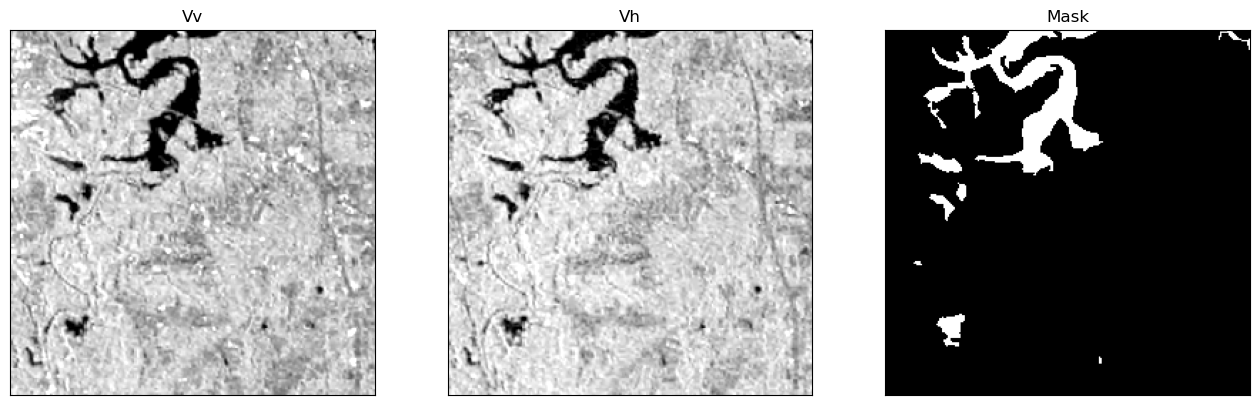

In [9]:
plot_random(train_set)

# 6679

/home/genrev_kiel_hizon/SAR_flood_segmentation/src/etci_dataset.py:14: RuntimeWarning: divide by zero encountered in true_divide
  ratio_image = np.clip(np.nan_to_num(vh_image / vv_image, 0), 0, 1)
/home/genrev_kiel_hizon/SAR_flood_segmentation/src/utils.py:22: RuntimeWarning: divide by zero encountered in true_divide
  x = (x - x_min) / (x_max - x_min)
/home/genrev_kiel_hizon/SAR_flood_segmentation/src/utils.py:22: RuntimeWarning: invalid value encountered in true_divide
  x = (x - x_min) / (x_max - x_min)


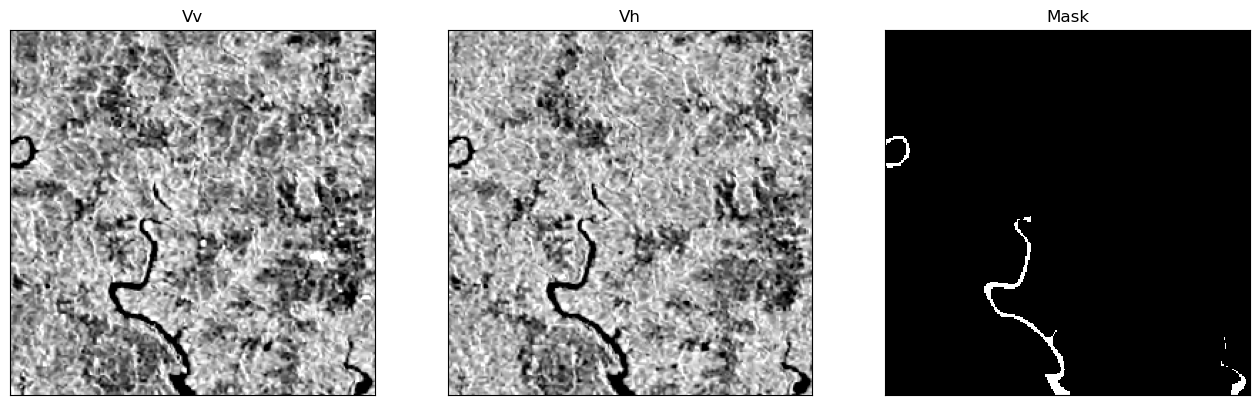

In [3]:
plot_sample(train_set[6679])